In [1]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda:0')

## Semantic loss using `cirkit`

So far, we used our logic circuit in a *traditional* setting, by running queries related to its logical semantics. However, when logic circuits also enable neuro-symbolic methods! In this notebook, we implement the **semantic loss** [(Xu et al, 2018)](https://proceedings.mlr.press/v80/xu18h.html) using an SDD.

Without going too deep into its details, the semantic loss relies on a logic circuit to implement contraints on the predictions of a neural network. Imagine we want to enforce constraints on the output $\hat{y}$ of a neural network and we want to model those contraints as a logic formula $F$ by considering each literal of $F$ as an element of $\hat{y}$. We know we can compile the formula $F$ into a logic circuit $\texttt{c}$ and that we can efficiently perform a bunch of operations (see [logic circuits](../logic-circuits)).

We may wish to quantify whether the output $\hat{y}$ actually satisfies these constraints. This is the core idea of the semantic loss, which is defined as $\mathcal{L}_{s}^\texttt{c}(\hat{y}) = -\texttt{c}(\hat{y})$.
The semantic loss is a plug-and-play type of loss: if we have our favourite loss function $\mathcal{L}(y, \hat{y})$, where $y$ are the target prediction, we can combine them as $\mathcal{L}' = \mathcal{L}(y, \hat{y}) + \gamma \mathcal{L}_{s}^\texttt{c}(\hat{y})$ where $\gamma$ is the *importance* that we place in correctly satisfying logical constraints. Minimizing $\mathcal{L}'$ means finding a model that minizes our favourite loss $\mathcal{L}$ while maximing the logical consistency of the predictions $\hat{y}$.

In this notebook, we follow one of the experiments on [(Xu et al, 2018)](https://proceedings.mlr.press/v80/xu18h.html) and implement a constraint that enforces mutual exclusivity between predictions. If we have a set $N = \{ C_1, C_2, \cdots, C_n \}$ of classes, then our logic formula will look like

$$
\alpha = (\lor_{C \in N} [C]) \land (\land_{C \neq D \in N } \lnot [C] \lor \lnot [D])
$$

where $[C]$ is the literal that corresponds to the class $C$ in the logic formula (and the circuit $\texttt{c}$).

Let's implement the logic circuit in `cirkit` first. We first define the constraint $\alpha$ with $|N| = 10$.

In [2]:
from operator import and_, or_
from functools import reduce
from itertools import combinations

from pysdd.sdd import Vtree, SddManager

N = 10

# define the SDD literals
vtree = Vtree(N, list(range(1, N + 1)), "balanced")
manager = SddManager.from_vtree(vtree)
alpha = reduce(or_, manager.vars) & reduce(and_, (~a | ~b for a, b in combinations(manager.vars, 2)))

And then we compile it to a boolean circuit. Before doing so, however, we have to clarify a little bit how and why the semantic loss works. If a logic circuit is decomposable and deterministic, we can replace its conjunctions and disjunctions with products and sums and its literals with indicator functions. This is the kind of translation `cirkit` relies upon internally. This is generally called an arithmetic circuit.

Since the inner components of the circuit are sums and products, its inputs (the literals of the original logic formula) will be numbers. If we use indicator functions to model assignment to a literal, we obtain an arithmetic circuit whose support is the same as the boolean circuit. We will just have output $0$ instead of $\bot$ (false) and $1$ instead of $\top$ (true).

We are not restricted into using indicator functions. If the input value represents a natural number, we can compute the Weighted Model Count of a logic formula and if we choose the input value carefully, we can perform probabilistic inference [(Chavira and Darwiche, 2008)](https://www.sciencedirect.com/science/article/pii/S0004370207001889).

In that case, we obtain a **probabilistic circuit** whose support is only the set of assignments that are also model for the logic formula $F$. Intuitively, we use the value $p \in [0, 1]$ for the input $[C]$ and the value $1 - p$ for the input $[\lnot C]$. Clearly, this is a binomial distribution over the class $C$ parametrized by the probability $p$. The output of the circuit $\texttt{c}(\hat{y}) = 1.0$ only if $[\hat{y}] \models F$. Additionally, we will have that $\texttt{c}(y) \in [0, 1)$ is the probability that the assignment $\hat{y}$ is a model for $F$. In other words we can evaluate the probability that the $\hat{y}$ is consistent with the constraint imposed by $F$.

Let's see how to compile \texttt{c} in `cirkit`. We first create our logic circuit and use as its inputs a `ParametricLayer`. Differently from other notebooks, a `ParametricLayer` does not represent a probability distribution, but rather represent an input that depends on an arbitrary internal parameter (which we will later replace with the outputs of the neural network).

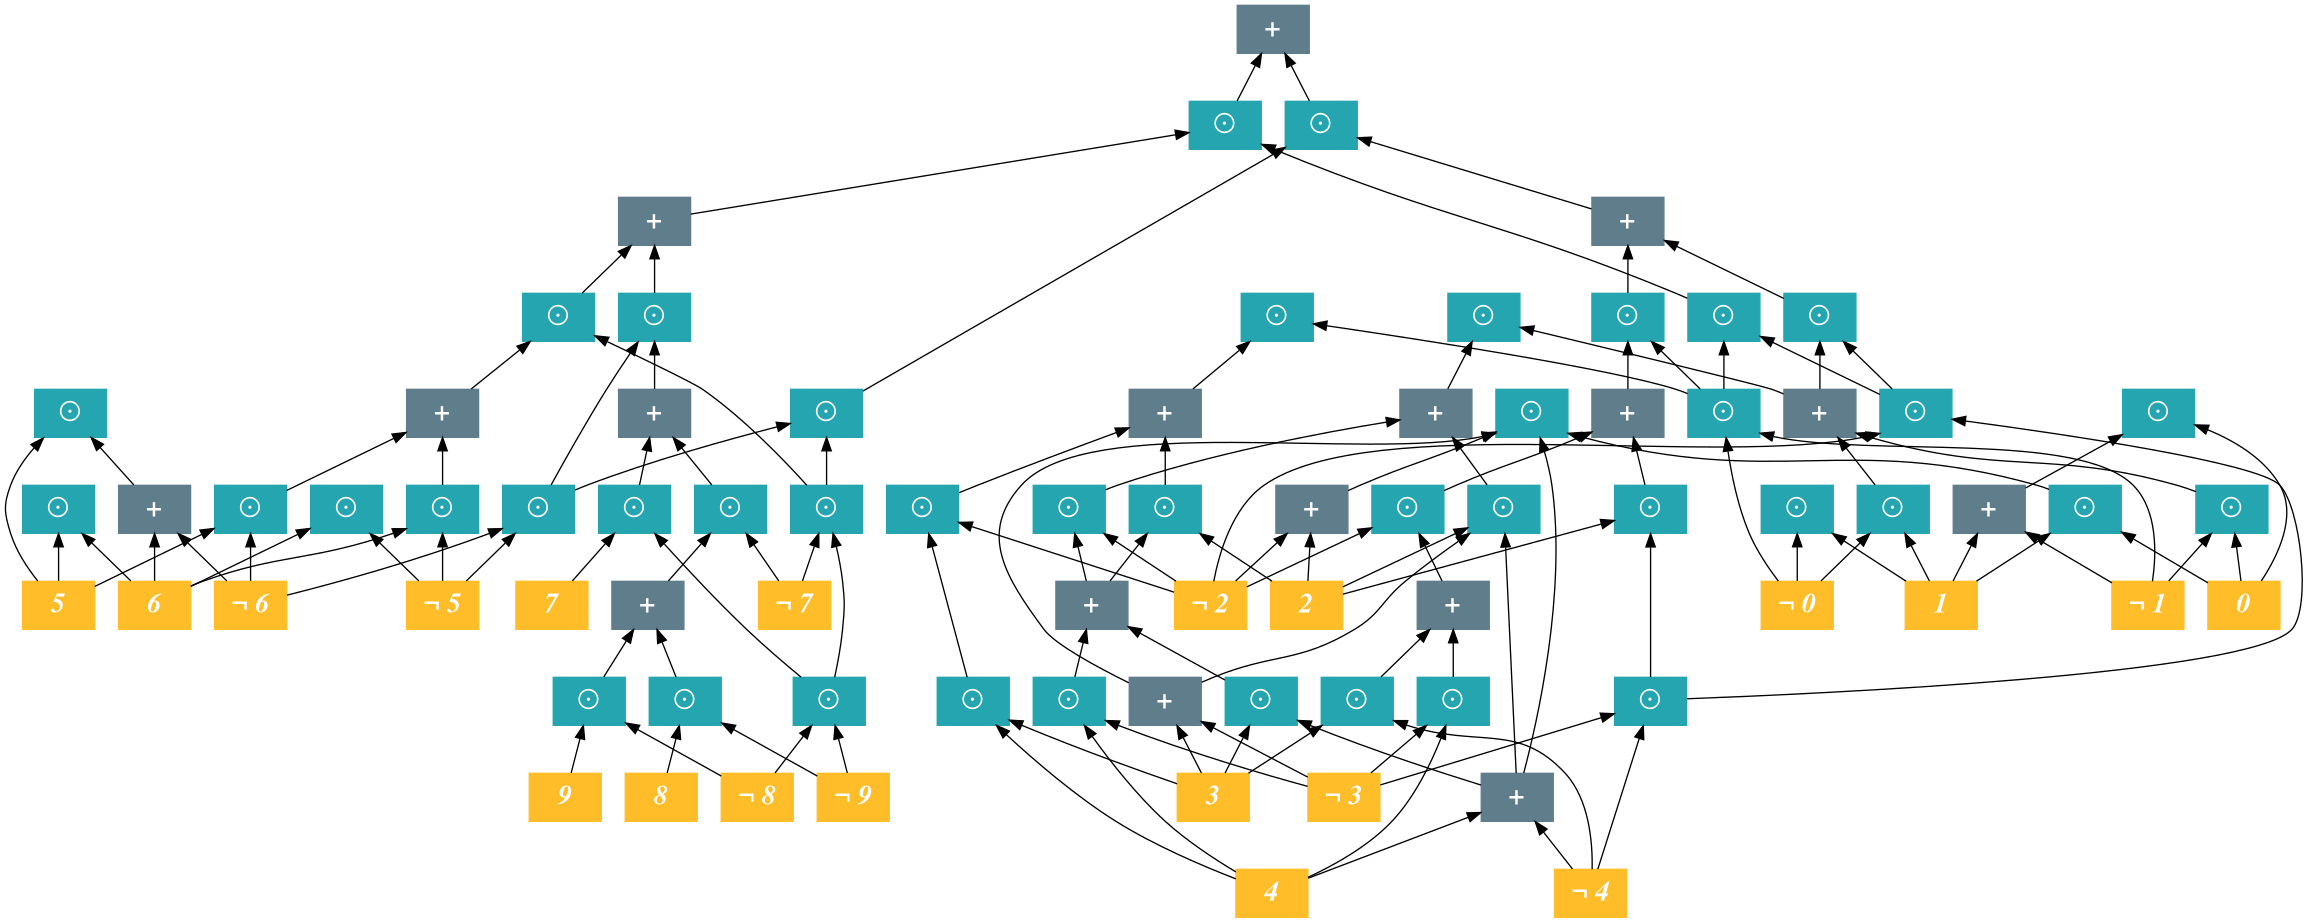

In [3]:
from tempfile import NamedTemporaryFile
from cirkit.templates.logic import SDD
from cirkit.symbolic.layers import ParametricLayer
from cirkit.symbolic.parameters import Parameter, ConstantParameter
from cirkit.symbolic.io import plot_circuit

from IPython.display import Image

with NamedTemporaryFile() as f:
    # export the SDD to a file
    alpha.save(f.name.encode())
    f.flush()

    # parse the SDD representation using the SDD class
    alpha_sdd = SDD.load(f.name)

    # define the literal factory which assigns to each literal a parametric input
    # we use the value 0. to initialize the parameter. Note that this value is irrelevant,
    # since we will conditionally parametrize it later
    def parametric_input_factory(scope, num_units, label):
        return ParametricLayer(
            scope, 
            num_output_units=num_units, 
            label=label, 
            parameter=Parameter.from_input(ConstantParameter(1, value=0.0))
        )

    alpha_symbolic = alpha_sdd.build_circuit(literal_input_factory=parametric_input_factory)

Image(plot_circuit(alpha_symbolic).pipe("png"))

We can create the propbabilistic circuit with inputs parametrized by the output of a neural network by constructing a conditional (probabilistic) circuit. A conditional circuit is a circuit where some of its parameters are parametrized through the use of a gate function [(Shao et al, 2022)](https://www.sciencedirect.com/science/article/pii/S0888613X21001766). A gate function is a general function that takes an input and output a parameter for the circuits. In our case, we will only parametrize the input layers implemented by `ParametricLayer`.

We can do this in `cirkit` by using the `condition_circuit` function, which takes as input the set of layers that we wish to parametrize.

In [4]:
from cirkit.templates.logic import LiteralNode, NegatedLiteralNode
from cirkit.symbolic.functional import condition_circuit

# we enforce an order on the literals to match the order of the predictions
parametrization_map = {
    "pos": sorted((i for i in alpha_symbolic.inputs if isinstance(i.label, LiteralNode)), key=lambda i: list(i.scope)[0]),
    "neg": sorted((i for i in alpha_symbolic.inputs if isinstance(i.label, NegatedLiteralNode)), key=lambda i: list(i.scope)[0]),
}

# conditionally parametrize alpha
conditional_alpha_symbolic = condition_circuit(alpha_symbolic, gate_functions=parametrization_map)

for gf_k, gf_shape in conditional_alpha_symbolic.gate_function_specs.items():
    print(f"Parameters {gf_k} need shape {gf_shape}")

Parameters pos.parameter.0 need shape (10, 1)
Parameters neg.parameter.0 need shape (10, 1)


We will need two different gate functions: one parametrizing the positive literals (corresponding to the classes $N$) and one parametrizing the negated literals (corresponding to the set $\{ \lnot C : C \in N \}$). Both gate function are required to produce similar parameter. Moreover, they will both take as input the prediction $\hat{y}$, since the parameters of $[C]$ and $[\lnot C]$ are a function of an element in $\hat{y}$.

In `cirkit` we instruct the compiler to use our provided gate function to parametrize the input layers and regularly compile the circuit.

In [5]:
from cirkit.pipeline import PipelineContext

ctx = PipelineContext(backend="torch", semiring="sum-product")

# positive literals are parametrized by the raw output of the neural network
def positive_gf(shape, p):
    return p.reshape(*shape)

ctx.add_gate_function("pos.parameter.0", positive_gf)

# negative literals are parametrized by the complement of raw output of the neural network
def negative_gf(shape, p):
    return (1 - p).reshape(*shape)

ctx.add_gate_function("neg.parameter.0", negative_gf)

circuit = ctx.compile(conditional_alpha_symbolic)

Let's see if if works out. Suppose the labels refer to the MNIST dataset (see the **region-graphs-and-parametrisation.ipynb** to see how images look like).
It would not surprise us too much if some model made confusion between 4s and 9s.
Hence, $y$ and $\hat{y}$ might look like

$$
y = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] \\
\hat{y} = [0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.3]
$$

The model correctly predicts the correct number ($4$), but is not too confident with it. As a result, $\hat{y}$ does satisfies the mutual exclusivity constraint with a low probability, which we can compute as $\texttt{c}(\hat{y})$.

In [6]:
import torch
y_hat = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.3]).unsqueeze(0)
circuit(y_hat, gate_function_kwargs={'pos.parameter.0': {'p': y_hat}, 'neg.parameter.0': {'p': y_hat}})

tensor([[[0.5800]]], grad_fn=<TransposeBackward0>)

Indeed, the circuit does not evaluate to $1$ since the prediction is not fully consistent with the logic circuit. However we correctly have that $\texttt{c}(y) = 1.0$ since it satisfiess the mutual exclusivity constraint.

In [7]:
y = torch.tensor([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]).unsqueeze(0)
circuit(y, gate_function_kwargs={'pos.parameter.0': {'p': y}, 'neg.parameter.0': {'p': y}})

tensor([[[1.]]], grad_fn=<TransposeBackward0>)

When the model places more probability mass on the correct prediction, we have an higher probability of satisfying the constraint. We can see this by building multiple one-hot encoded prediction for a random class $i \in N$, scale them by different factors $\lambda$ and use a softmax activation. We obtain a probability distribution where the amount of probability mass on the prediction $i$ depends on $\lambda$.

/tmp/ipykernel_460636/2666109538.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.1f}" for x in l[::100]])


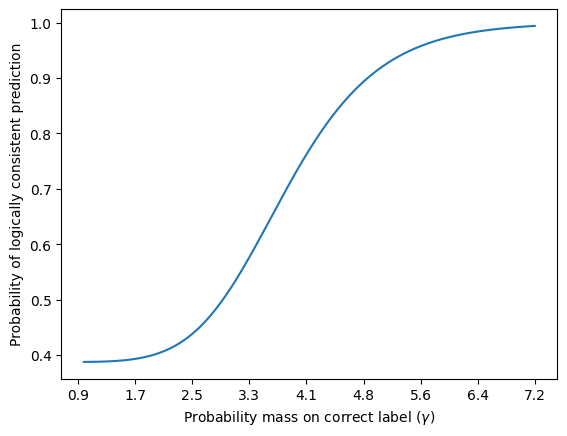

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

l = torch.linspace(0.1, 8, 1000)
preds = torch.zeros(1000, 10)
preds[torch.arange(1000), torch.randint(0, 10, size=(1000,))] = l
preds = preds.softmax(dim=-1)

logic_satisfaction = circuit(preds, gate_function_kwargs={'pos.parameter.0': {'p': preds}, 'neg.parameter.0': {'p': preds}})
logic_satisfaction = logic_satisfaction.detach().flatten()

ax.plot(l, logic_satisfaction)
ax.set_xticklabels([f"{x:.1f}" for x in l[::100]])

ax.set_xlabel(r"Probability mass on correct label ($\gamma$)")
ax.set_ylabel("Probability of logically consistent prediction")
plt.show()

Clearly, the more probability mass we have on the correct prediction, the more likely we are to have mutually exclusive predictions. Enforcing mutual exclusivity forces a model to be more confident in its predictions.

We can see if this enhances the performances of a neural network on a classification task. We will try to solve the classic MNIST benchmark by using a neural network with one hidden layer. We will use a small neural network composed of an MLP with one hidden layer with as few as $16$ hidden dimensions and a ReLU activation. This will allow us to see if, alongside obtaining consistent prediction, semantic loss allows a smaller models to build more effective decision boundaries.

We will use standard cross entropy as loss $\mathcal{L}$ and use $\gamma = 1.0$ as the semantic loss weight.

In [11]:
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

# Load the MNIST data set and data loaders
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=64)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=64)

mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
).to(device)

# Initialize a torch optimizer of your choice
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

# move circuit to device
circuit = circuit.to(device)

We first evaluate how the MLP model performs on the task without any semantic loss. At each epoch we evaluate the accuracy of the predictions as well as the average probability of the predictions being consistent with $F$.

In [13]:
num_epochs = 5
respects_mutex = 0.0
correct_predictions = 0.0
running_samples = 0

for epoch_idx in range(num_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        # compute the predictions using the MLP
        pred = mlp(x.to(device))
        
        # on the baseline, our loss is simply cross entropy
        loss = torch.nn.functional.cross_entropy(pred, y.to(device))
        
        # Update the parameters of the circuits, as any other model in PyTorch
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # compute the accuracy and logical correctness on the testing set
    correct_predictions = 0.0
    logically_correct_predictions = 0.0
    for x, y in test_dataloader:
        with torch.no_grad():
            pred = mlp(x.to(device))
            correct_predictions += (pred.argmax(dim=-1) == y.to(device)).sum()

            # we compute the logical consistency of the predictions by measuring the probability
            # that they satisfy the logic formula
            p_pred = pred.softmax(dim=-1)
            logically_correct_predictions += circuit(
                p_pred, 
                gate_function_kwargs={
                    'pos.parameter.0': {'p': p_pred}, 
                    'neg.parameter.0': {'p': p_pred}
            }).sum().cpu().item()
    
    logic_accuracy = logically_correct_predictions / len(data_test)
    accuracy = correct_predictions / len(data_test)
    print(f"Epoch: {epoch_idx} | Accuracy: {accuracy:.3f} | Constraint accuracy: {logic_accuracy:.3f}")

Epoch: 0 | Accuracy: 0.940 | Constraint accuracy: 0.905
Epoch: 1 | Accuracy: 0.936 | Constraint accuracy: 0.919
Epoch: 2 | Accuracy: 0.936 | Constraint accuracy: 0.922
Epoch: 3 | Accuracy: 0.943 | Constraint accuracy: 0.935
Epoch: 4 | Accuracy: 0.942 | Constraint accuracy: 0.934


Of course the model achieves some level of logical consistency, but it is not a priority. Let's see what happens when we explicitly enforce mutual exclusivity.

In [14]:
# reset the parameters of the MLP
for layer in mlp:
    if len(list(layer.parameters())) > 0:
        layer.reset_parameters()

respects_mutex = 0.0
correct_predictions = 0.0
for epoch_idx in range(num_epochs):
    for i, (x, y) in enumerate(train_dataloader):
        # compute predictions and cross entropy loss as in the baseline
        pred = mlp(x.to(device))
        loss = torch.nn.functional.cross_entropy(pred, y.to(device))
        
        # we now prepare the input to the constraint circuit
        # as done previously in the testing phase
        circuit_input = pred.softmax(dim=-1)
        
        # and compute the semantic loss
        semantic_loss = circuit(
            circuit_input, 
            gate_function_kwargs={
                'pos.parameter.0': {'p': circuit_input}, 
                'neg.parameter.0': {'p': circuit_input}
        }).mean()
        
        # the overall loss is a simple combination of loss and semantic loss
        loss = loss - (1.00 * semantic_loss)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    correct_predictions = 0.0
    logically_correct_predictions = 0.0
    for x, y in test_dataloader:
        with torch.no_grad():
            pred = mlp(x.to(device))
            correct_predictions += (pred.argmax(dim=-1) == y.to(device)).sum()
            
            p_pred = pred.softmax(dim=-1)
            logically_correct_predictions += circuit(
                p_pred, 
                gate_function_kwargs={
                    'pos.parameter.0': {'p': p_pred}, 
                    'neg.parameter.0': {'p': p_pred}
            }).sum().item()

    logic_accuracy = logically_correct_predictions / len(data_test)
    accuracy = correct_predictions / len(data_test)
    print(f"Epoch: {epoch_idx} | Accuracy: {accuracy:.3f} | Constraint accuracy: {logic_accuracy:.3f}")

Epoch: 0 | Accuracy: 0.932 | Constraint accuracy: 0.939
Epoch: 1 | Accuracy: 0.936 | Constraint accuracy: 0.948
Epoch: 2 | Accuracy: 0.942 | Constraint accuracy: 0.944
Epoch: 3 | Accuracy: 0.943 | Constraint accuracy: 0.953
Epoch: 4 | Accuracy: 0.944 | Constraint accuracy: 0.952


The model's predictions are more consistent with the constraint and as a byproduct, we also obtain a more accurate model!
The parameter $\gamma$ plays a big role on balancing the trade-off between accurate predictions and logically consistent predictions. Try different values of $\gamma$ and see if you can obtain a better model, both from accuracy and logical consistency points of view.